## Mapping Infrastructural Damage due to Beirut Blast

## Table of Contents

* [Introduction](#1)
* [Necessary imports](#2)
* [Connect to your GIS](#3)
* [Get the data for analysis](#4)
* [Methodology](#5)
* [Prepare data for analysis](#6)
    * [Create geometry of aoi ](#7)
    * [Filter out sentinel-2 tiles](#8)
    * [Extract bands](#9)
* [Generate water bodies mask](#10)
    * [Create normalized difference water index raster](#11)
    * [Create binary raster](#12)
    * [Extract water polygons](#13)
    * [Masking out noise area](#14)
* [Extract damaged area](#15)
    * [Get Normalized difference building index raster](#16)
    * [Create continous built-up raster](#17)
    * [Create difference raster](#18)
    * [Get the damaged area](#19)
    * [Hotspots analysis](#20)
* [Visualize results](#21)
    * [Interpretation of results](#23)
* [Conclusion](#24)
* [Literature resources](#25)

## Introduction <a class="anchor" id="1"></a>

On August 4, 2020, a fire started in Warehouse 12 near the grain silos at The port of Beirut located on the northern Mediterranean coast. The warehouse containing around 2700 tonnes of ammonium nitrate (highly explosive chemical used in manufacturing of fertilizer) exploded creating a mushroom cloud causing a huge explosion followed by few small explosions. Approximately 200 people died, more than 6,000 people were injured, and property worth US$15 billion was damaged making 300,000 people homeless.

The shockwaves were felt in parts of Europe, Israel, Palestine, Syria and Turkey. The blast was heard in Cyprus, approximately 250 km away from Beirut. The shockwaves of magnitude 3.3, caused due to explosion, were detected by the seismograph of United States Geological Survey. According to [reports](https://www.standard.co.uk/news/world/beirut-explosion-one-of-largest-blasts-history-a4517646.html), the Beirut explosion is considered as one of the most powerful non-nuclear explosions in history.

Performing field surveys after explosions can be risky and extremely difficult. A great alternative is to use satellite remote sensing data. Satellite data is able to cover the spatial extent of damage caused due to explosion.

This study uses Sentinel-2 multispectral data to map the extent of infrastructural damage. The spatial resolution of Sentinel-2 is 10m which covers infrastructural details better than Landsat with 30m spatial resolution.

## Neccessary Imports <a class="anchor" id="2"></a>

In [1]:
import arcgis
from arcgis import *
from datetime import datetime
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.raster.analytics import convert_feature_to_raster, convert_raster_to_feature
from arcgis.raster.functions import greater_than, clip, apply
from arcgis.features.analysis import dissolve_boundaries
from ipywidgets import HBox, VBox, Label, Layout

## Connect to your GIS <a class="anchor" id="3"></a>

In [2]:
from arcgis import GIS
agol_gis = GIS("home")
ent_gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

## Get the data for analysis <a class="anchor" id="4"></a>

[Sentinel-2 Views](https://www.arcgis.com/home/item.html?id=fd61b9e0c69c4e14bebd50a9a968348c) is used in the analysis: this multitemporal layer consists 13 bands with 10, 20, and 60m spatial resolution.. The imagery layer is rendered on-the-fly and available for visualization and analytics.  This imagery layer pulls directly from the Sentinel-2 on AWS collection and is updated daily with new imagery.

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
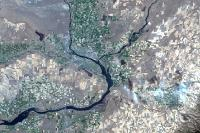

In [3]:
s2 = agol_gis.content.get('fd61b9e0c69c4e14bebd50a9a968348c')
sentinel = s2.layers[0]
s2

<Item title:"beirut_aoi" type:Feature Layer Collection owner:api_data_owner>
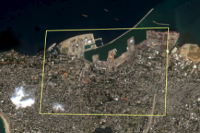

In [4]:
aoi1 =  agol_gis.content.search('title:beirut_aoi', 'Feature Layer Collection')[0]
aoi1

## Prepare data for analysis <a class="anchor" id="6"></a>

`Sentinel-2 Views` imagery layers consists data for whole world. The first step is to filter out the before and after explosion data of the study area for this analysis.

### Create geometry of area of interest (AOI) <a class="anchor" id="7"></a>

The geometry of AOI is created for filtering out the Sentinel-2 tiles for the study area.

In [5]:
aoi_layer = aoi1.layers[0]
aoi_feature = aoi_layer.query()
aoi_geom = aoi_feature.features[0].geometry
aoi_geom['spatialReference'] = {'wkid':3857}

### Filter out sentinel-2 tiles  <a class="anchor" id="8"></a>

In [6]:
m = gis2.map('Beirut', 14)
m

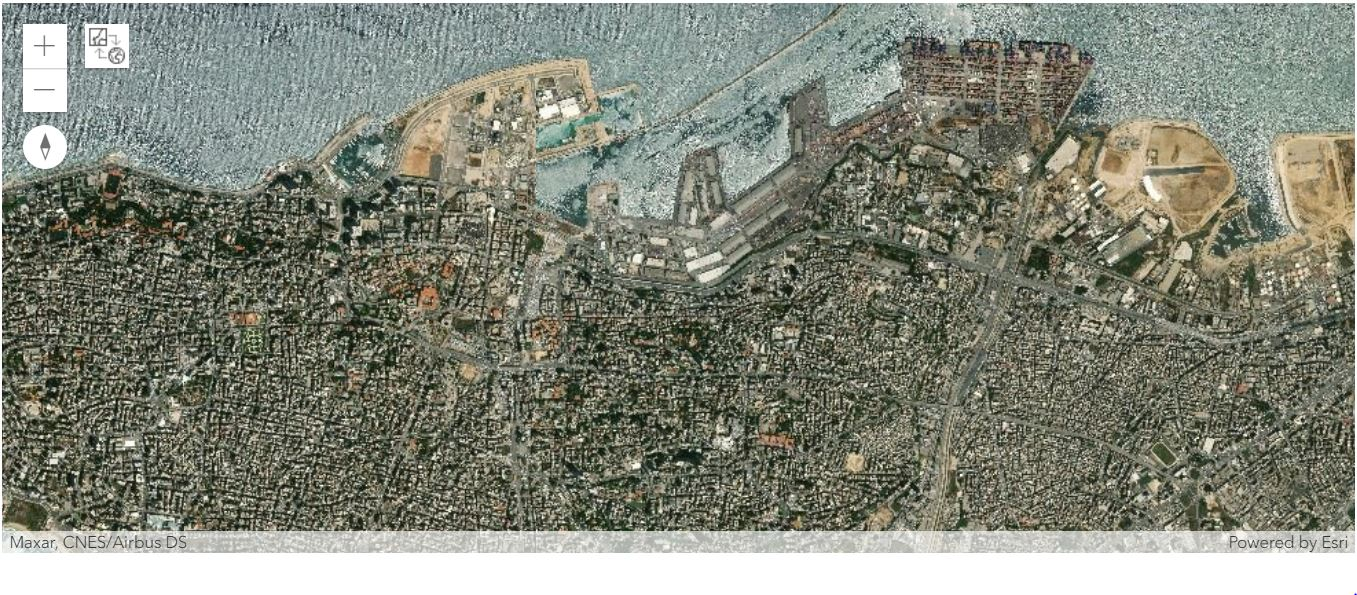

In [7]:
m.zoom_to_layer(aoi1)
m.basemap='satellite'

#### Before blast

Imagery of 2 days were filtered, Tile for July 24, 2020 represents the before explosion scenario.

In [8]:
from datetime import datetime
selected = sentinel.filter_by(where="(Category = 1)",
                             time=[datetime(2020, 7, 20), datetime(2020, 8, 4)],
                             geometry=arcgis.geometry.filters.intersects(aoi_geom))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf

df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df

,objectid,acquisitiondate,groupname,cloudcover,dayofyear,shape_Length,shape_Area,SHAPE,AcquisitionDate
0,11567718,2020-07-24 08:30:51,20200724T083050_36SYC_0,0.0106,206,526689.842535,1.733726e+10,"{""rings"": [[[4047851.298300002, 4068244.3015],...",2020-07-24 08:30:51
1,11516426,2020-07-29 08:30:48,20200729T083047_36SYC_0,0.0364,211,526689.842535,1.733726e+10,"{""rings"": [[[4047851.298300002, 4068244.3015],...",2020-07-29 08:30:48
2,11608519,2020-08-03 08:30:51,20200803T083051_36SYC_0,0.0624,216,526689.842535,1.733726e+10,"{""rings"": [[[4047851.298300002, 4068244.3015],...",2020-08-03 08:30:51


In [9]:
s2_bb = apply(sentinel, 'Natural Color with DRA')
s2_bb.mosaic_by(lock_rasters=[11567718])
s2_bb.extent = m.extent
#s2_bb.save('s2_20200724_f', gis=gis2)
s2_bb = gis2.content.search('s2_20200724_f')[0]
s2_bb_lyr = s2_bb.layers[0]

#### After blast
Tile for August 08, 2020 represents the after blast scenerio of Beirut Port.

In [10]:
selected = sentinel.filter_by(where="(Category = 1)",
                             time=[datetime(2020, 8, 5), datetime(2020, 8, 12)],
                             geometry=arcgis.geometry.filters.intersects(aoi_geom))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf

df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df

,objectid,acquisitiondate,groupname,cloudcover,dayofyear,shape_Length,shape_Area,SHAPE,AcquisitionDate
0,11664437,2020-08-08 08:30:48,20200808T083048_36SYC_0,0.0342,221,526689.842535,1.733726e+10,"{""rings"": [[[4047851.298300002, 4068244.3015],...",2020-08-08 08:30:48


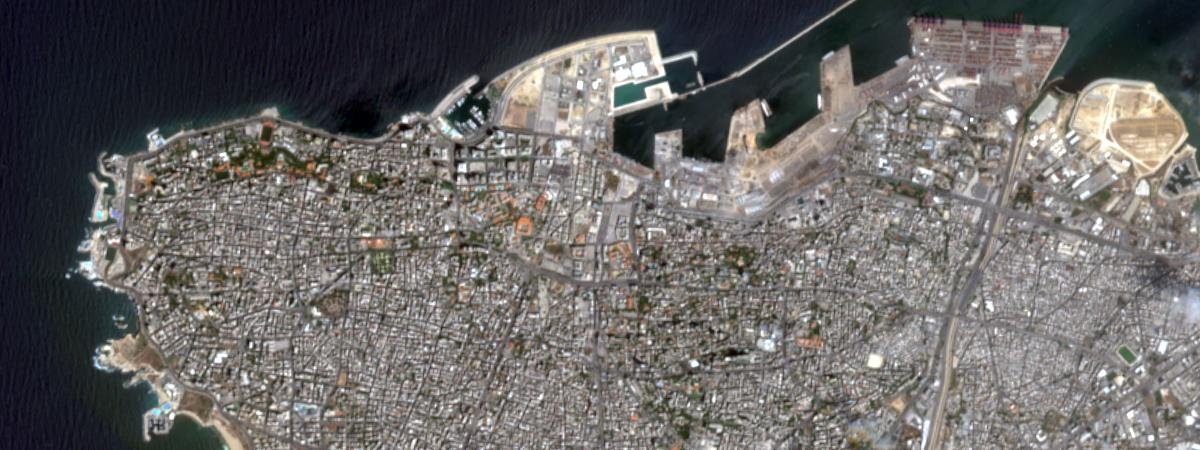

In [11]:
s2_bb = apply(sentinel, 'Natural Color with DRA')
s2_bb.mosaic_by(lock_rasters=[11664437])
s2_bb.extent = m.extent
s2_bb.save('s2_20200808_f', gis=gis2)
s2_bb

## Generate water bodies mask<a class="anchor" id="10"></a>

### Create normalized difference water index raster<a class="anchor" id="11"></a>

Normalized Difference Water Index (NDWI) is most suitable for mapping of water bodies, droughts, boundary evaluation. Water bodies have strong absorbability and low radiation within the visible to infrared spectral ranges and NDWI is based on this phenomenon. Default rendering function of  Normalized Difference Water Index (NDWI) is computed as Green(Band03)-NIR(Band08)/ Green(Band03)+NIR(Band08). To get the [NDWI Raw](https://www.arcgis.com/home/item.html?id=112db40d3640473aacb0d1f891462496) raster for the corresponding Sentinel-2 tile `apply` function was used.
Rendering (or display) of band combinations and calculated indices is done on-the-fly from the source images via Raster Functions. 

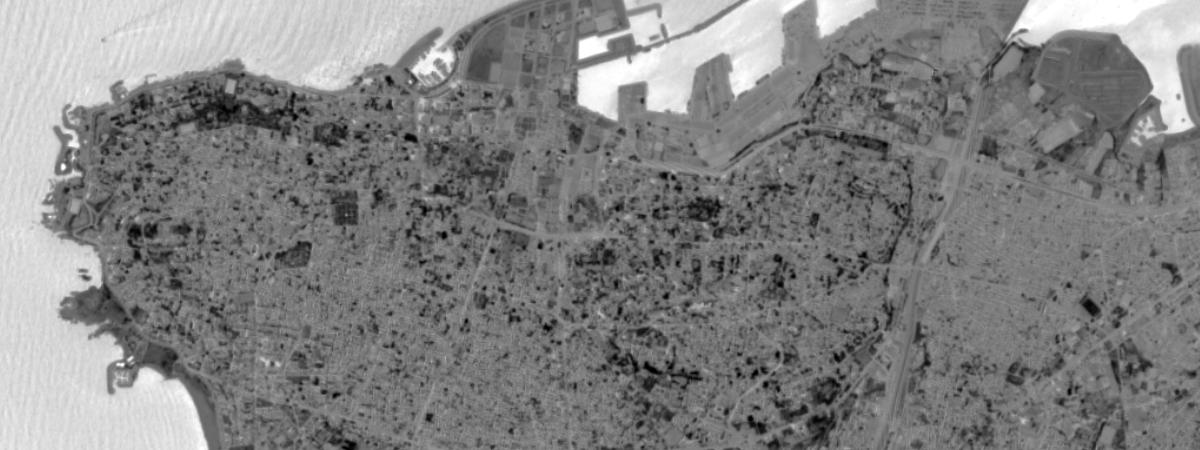

In [12]:
ndwi1 = apply(sentinel, 'NDWI Raw')
ndwi1.mosaic_by(lock_rasters=[11567718])
ndwi1.extent = m.extent
#ndwi_lyr = ndwi1.save('ndwi_lyr1')
ndwi1

### Create binary raster<a class="anchor" id="12"></a>

The binary rasters were converted to feature layer for extracting the boundaries of water bodies. [greater_than](https://pro.arcgis.com/en/pro-app/help/data/imagery/greater-than-function.htm) function was used to create a binary raster where pixels with value greater than 0.08 were assigned as 1 and others pixels were assigned value of 0.

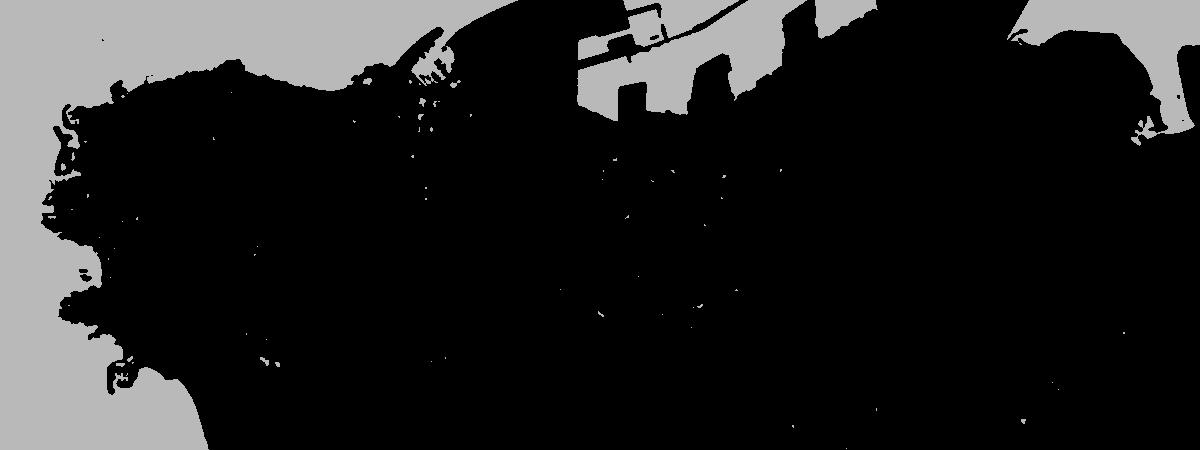

In [13]:
water_mask = greater_than([ndwi1, 0.08],
                          extent_type='FirstOf', 
                          cellsize_type='FirstOf', 
                          astype='U16')
water_mask

### Extract water polygons<a class="anchor" id="13"></a>

In the feature layer 'gridcode=0' represents non water class and 'gridcode=1' represents water class. Water polygons were selected using the `query` function from the dataframe of feature layer. A new feature layer was created using `gis.content.import` function which will only consist the water polygons.

In [14]:
water_poly = convert_raster_to_feature(water_msk.layers[0], 
                                       field='Value', 
                                       output_type='Polygon', 
                                       simplify=True, 
                                       output_name=None, 
                                       gis=gis2)

In [15]:
dfm=water_poly.layers[0].query('gridcode=0').sdf 
nwater_poly=gis2.content.import_data(dfm, title='nwpoly22212')

### Masking out noise area<a class="anchor" id="14"></a>

The first row of pixel along the coast has very high reflectance which is considered as noise and can manipulate the results. [create_buffer](https://developers.arcgis.com/python/api-reference/arcgis.features.analysis.html#create-buffers) function was used to remove the noise area. Sentinel-2 spatial resolution is 10 m, so negative buffer of 10m was created.

In [16]:
buffer = arcgis.create_buffers(nwater_poly.layers[0], 
                               distances=[-10], 
                               field=None, 
                               units='Meters', 
                               dissolve_type='None', 
                               ring_type='Disks', 
                               side_type='Full', 
                               end_type='Round', 
                               output_name=None,
                               gis=gis2) 

As the buffer polygons will be used for masking out the water pixels from the raster. [dissolve_boundaries](https://developers.arcgis.com/python/api-reference/arcgis.features.analysis.html#dissolve-boundaries) function was used to get a combined geometry of all polygons with `gridcode=0`.

In [17]:
diss_f = dissolve_boundaries(buffer,
                             dissolve_fields=['gridcode'], 
                             output_name='dissolve_poly_f3', 
                             gis=gis2,  
                             multi_part_features=True)

The geometry of `diss_f` was created for masking out the water pixels from the study area.

In [18]:
aoi2_layer = diss_f.layers[0]
aoi2_feature = aoi2_layer.query(where='gridcode=0')
aoi2_geom = aoi2_feature.features[0].geometry
aoi2_geom['spatialReference'] = {'wkid':3857}

## Get the damaged area<a class="anchor" id="15"></a>

### Get Normalized Difference Built-Up Index rasters<a class="anchor" id="16"></a>
The NDBI highlights urban areas with higher reflectance in the shortwave-infrared (SWIR) region, compared to the Near Infra-red (NIR) region. Applications include watershed runoff predictions, built-up mapping and land-use planning.
The formula for computing Normalized Difference Built-Up Index is SWIR(Band11)-NIR(Band8)/ SWIR(Band11)+NIR(Band8). Sentinel-2 View `visual rendering` was used to get NDBI rasters. Rendering (or display) of band combinations and calculated indices is done on-the-fly from the source images via Raster Functions. To get the NDBI raster for the corresponding  Sentinel-2 tile `apply` function was used.

In [19]:
ndbi1 = apply(sentinel, 'Normalized Difference Built-Up Index (NDBI)')
ndbi1.mosaic_by(lock_rasters=[11567718])
ndbi1.extent = m.extent
ndbi_r = ndbi1.save('s2_ndbi_20200724_f2', gis=gis2)
ndbi_lyr1 = ndbi_r.layers[0]

In [20]:
ndbi2 = apply(sentinel, 'Normalized Difference Built-Up Index (NDBI)')
ndbi2.mosaic_by(lock_rasters=[11664437])
ndbi2.extent = m.extent
ndbi2_r = ndbi2.save('s2_ndbi_20200808_f2', gis=gis2)
ndbi_lyr2 = ndbi2_r.layers[0]

In [21]:
ndbi_r = gis2.content.search('s2_ndbi_20200724_f')[0]
ndbi_lyr1 = ndbi_r.layers[0]
ndbi2_r = gis2.content.search('s2_ndbi_20200808_f')[0]
ndbi_lyr2 = ndbi2_r.layers[0]

## Create continous built-up raster<a class="anchor" id="17"></a>
NDBI and NDWI rasters were used to extract the built-up areas using the following formula: `NDBI - NDWI`. In this raster the negative values will represent water pixels and positive values represent built-up pixels.

In [22]:
## continous raster showing before blast scenerio
bb = ndbi_lyr1 - ndwi_lyr.layers[0]
bb_wwater = bb.save('bb_wwater')

In [23]:
## continous raster showing after blast scenerio
ab = ndbi_lyr2 - ndwi_lyr.layers[0]
ab

### Create difference raster<a class="anchor" id="18"></a>

The continuous rasters for before blast and after blast were subtracted to create a difference raster which shows the areas that have variation in NDBI value after the blast.

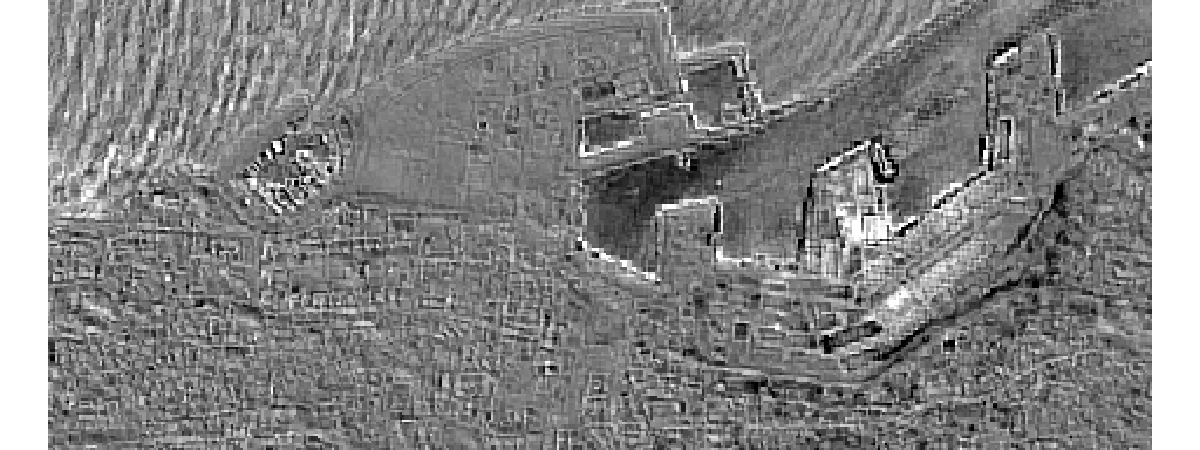

In [24]:
difference_ras = bb - ab
diff_ras = difference_ras.save('diff_raster_f1', gis=gis2)
difference_ras

As this analysis is focused on built-up damage, NDWI water mask was used to clip out the water pixels from the raster.

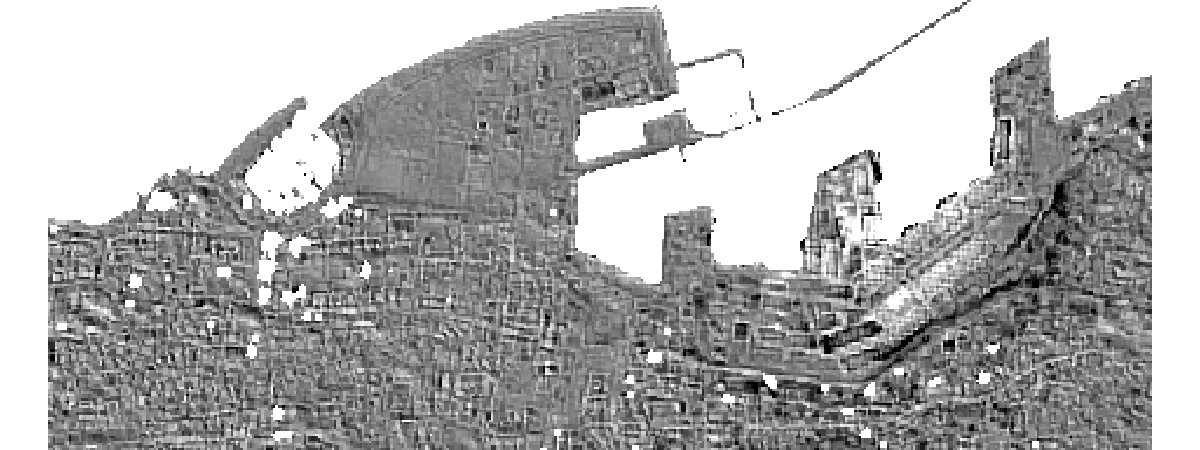

In [25]:
clip_diff = clip(difference_ras, aoi2_geom)
clip_diff_ras = clip_diff.save("cl_diff_ras1", gis=gis2)
clip_diff_ras.layers[0]

### Get the damaged area<a class="anchor" id="19"></a>
#### Get point feature layer

Hotspot analysis is necessary to get the damaged area polygon. [find_hot_spots](https://developers.arcgis.com/python/api-reference/arcgis.features.analysis.html#find-hot-spots) function requires point input layer. The raster was converted to point feature layer using [convert_raster_to_feature](https://enterprise.arcgis.com/en/portal/latest/use/geoanalytics-find-hot-spots.htm) function.

In [26]:
b_pt = convert_raster_to_feature(clip_diff_ras.layers[0], 
                                        field='Value', 
                                        output_type='Point', 
                                        simplify=True, 
                                        output_name='contest_pt1', 
                                        gis=gis2)

### Hotspots analysis<a class="anchor" id="20"></a>
[find_hot_spots](https://developers.arcgis.com/python/api-reference/arcgis.features.analysis.html#find-hot-spots) function was used to get the damaged area.

In [27]:
hspot1 = arcgis.features.analysis.find_hot_spots(b_pt, 
                                                analysis_field='grid_code',
                                                output_name='wwater_hspots', 
                                                gis=gis2)

The resulting point layer has both cold and hotspots. Points representing hotspots were filtered out using `query` on the data frame. Points with value greater than 1 in `gi_bin` column were taken and `gis.content.import` function was used to create a feature layer from the data frame. `gi_bin>1` represents Hot Spots and Negative values represents Cold Spots.

In [28]:
dfm1 = hspot1.layers[0].query('gi_bin>1').sdf 
damg_pt = gis2.content.import_data(dfm1, title='hspots4')
dfm1

,objectid,source_id,grid_code,gipvalue,gizscore,gi_bin,gi_text,nneighbors,SHAPE
0,5,5,-0.004153,0.000868,3.330064,3,Hot Spot with 99% Confidence,11,"{""x"": 3953044.8856000006, ""y"": 4016512.2457000..."
1,8,8,0.085389,0.000204,3.713943,3,Hot Spot with 99% Confidence,19,"{""x"": 3952884.8856999986, ""y"": 4016502.2458000..."
2,9,9,0.085389,0.000369,3.561146,3,Hot Spot with 99% Confidence,20,"{""x"": 3952894.8856999986, ""y"": 4016502.2458000..."
3,10,10,0.060912,0.000533,3.463781,3,Hot Spot with 99% Confidence,21,"{""x"": 3952904.8856999986, ""y"": 4016502.2458000..."
4,11,11,-0.006446,0.000383,3.551386,3,Hot Spot with 99% Confidence,22,"{""x"": 3952914.8858000003, ""y"": 4016502.2458000..."
...,...,...,...,...,...,...,...,...,...
5209,59232,59232,-0.017200,0.005532,2.774285,2,Hot Spot with 95% Confidence,34,"{""x"": 3953294.8856000006, ""y"": 4014642.2459999..."
5210,59603,59603,-0.089017,0.006576,2.717610,2,Hot Spot with 95% Confidence,29,"{""x"": 3952354.8858999982, ""y"": 4014632.2459999..."
5211,59892,59892,0.053100,0.002202,3.061515,2,Hot Spot with 95% Confidence,22,"{""x"": 3950624.886, ""y"": 4014622.246100001, ""sp..."
5212,59893,59893,-0.013931,0.001664,3.144524,2,Hot Spot with 95% Confidence,22,"{""x"": 3950634.886, ""y"": 4014622.246100001, ""sp..."


The point layer was converted to raster using [convert_feature_to_raster](https://developers.arcgis.com/python/api-reference/arcgis.raster.analytics.html?highlight=convert_feature_to_raster#convert-feature-to-raster) function. Raster of 10m spatial resolution was created using the `gi_bin` column.

In [29]:
dmg_ras = arcgis.raster.analytics.convert_feature_to_raster(damg_pt.layers[0],
                                                            {'distance':10,'units':'meters'}, 
                                                            value_field='gi_bin', 
                                                            output_name='damage_ras',  
                                                            gis=gis2)

The `dmg_ras` was further converted to polygon for better vizualization of results. The `dmg_poly` layer was dissolved to get the extent layer which will show the built-ups which were affected by the explosion.

In [30]:
dmg_ras = gis2.content.search('damage_ras')[0]
## Get the damaged polygon from raster
dmg_poly = convert_raster_to_feature(dmg_ras.layers[0], 
                                       field='Value', 
                                       output_type='Polygon', 
                                       simplify=True, 
                                       output_name=None, 
                                       gis=gis2)

## buffer was created of 10m
damg_poly = arcgis.create_buffers(dmg_poly, 
                               distances=[10], 
                               field=None, 
                               units='Meters', 
                               dissolve_type=None, 
                               ring_type='Disks', 
                               side_type='Full', 
                               end_type='Flat', 
                               output_name='damg_poly10',
                               gis=gis2)
## The polygons were dissolved to get the extent 
diss = arcgis.dissolve_boundaries(damg_poly,
                                  output_name='diss_poly7',
                                  gis=gis2,
                                  multi_part_features=True)

## Visualize results<a class="anchor" id="21"></a>

#### Create map widget

In [31]:
m1 = gis2.map('Beirut', 14)
m

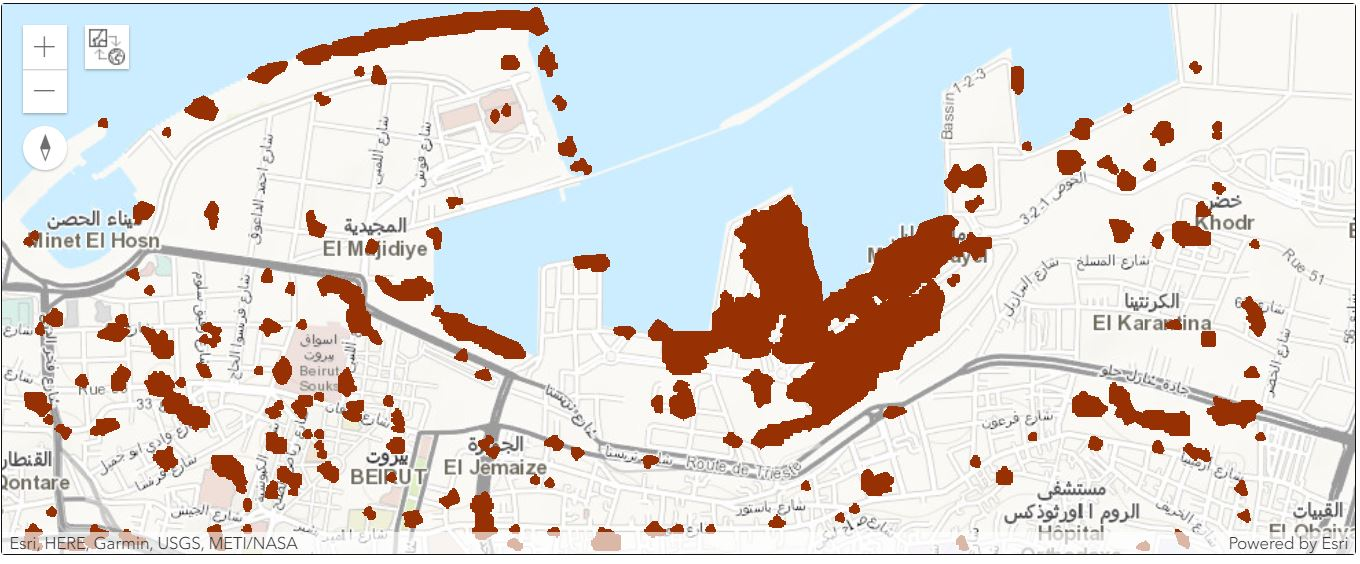

#### Add data to map widget

In [32]:
diss = gis2.content.search('diss_poly7')[0]
dfm4 = diss.layers[0].query().sdf 
dfm4

,objectid,count,analysisarea,SHAPE
0,1,656,0.258229,"{""rings"": [[[3953947.1204493307, 4015846.14764..."


In [33]:
dfm4.spatial.plot(map_widget=m1,
                   renderer_type='u',  
                   method='esriClassifyNaturalBreaks',  
                   class_count=2,  
                   col='objectid',  
                   cmap='Oranges',
                   outline_color=[0,0,0,0],
                   alpha=1
                   )

True

### Interpretation of results<a class="anchor" id="23"></a>

The map widgets shows buildings which were damaged due to the explosion. Infrastructure on port was fully damaged due to the explosion and the buildings in the buffer area of 10 km were partially damaged. According to reports, approximately 7km infrastructure was damaged due to explosion.

## Conclusion<a class="anchor" id="24"></a>

On August 4, 2020, one of history's most powerful non-nuclear explosion occurred at The Port of Beirut. The shockwaves were felt in parts of Europe, Israel, Palestine, Syria, Cyprus and USA.. In this study, Sentinel-2 multispectral data is used to map the extent of infrastructural damage caused due to the explosion. The results shows approximately 7 km area was affected by the blast. The same methodology can be used to estimate the extent of damage caused due to explosion for different regions with Sentinel-2 data using ArcGIS platform.

## Literature resources<a class="anchor" id="25"></a>

|Literature | Source | Link |
| -| - |-|
| Article   | Beirut blast|https://www.bbc.com/news/world-middle-east-53656220|
| Article   |Beirut Blast|https://www.standard.co.uk/news/world/beirut-explosion-one-of-largest-blasts-history-a4517646.html|